In [1]:
from scipy.ndimage.interpolation import zoom
from scipy.misc import imsave
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data, img_as_float
from scipy import ndimage as ndi
from scipy.spatial import distance
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from pydicom import dcmread
from pydicom.filereader import read_dicomdir
from os.path import dirname, join
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

os.chdir('D:\\DS PROJECT\\CT\\01_Samodurov\\DICOM\\PA000000\\ST000000\\SE000003')
os.getcwd()

'D:\\DS PROJECT\\CT\\01_Samodurov\\DICOM\\PA000000\\ST000000\\SE000003'

In [2]:
filepath = 'D:\\DS PROJECT\\CT\\01_Samodurov\\DICOMDIR'
dicom_dir = read_dicomdir(filepath)
base_dir = dirname(filepath)

image_files = [join(base_dir, *image_desc.ReferencedFileID) for image_desc in dicom_dir.patient_records[0].children[0].children[3].children]
slices = [dcmread(filename) for filename in image_files]
images = np.array([sl.pixel_array for sl in slices])

In [ ]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, sharex='col', sharey='row', figsize=(50, 50))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap='gray') 
        
plot_ct_scan(images)

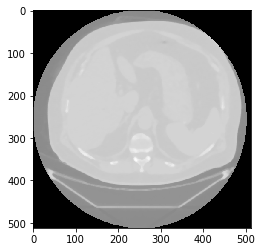

In [4]:
imgg = images[400]
# imgg = images[375]
imgg = cv2.medianBlur(imgg, 7)

plt.imshow(imgg, cmap='gray')

(array([60472.,     0.,     0.,     0.,     0., 48923.,  6169., 68741.,
        77169.,   670.]),
 array([-2000. , -1629.3, -1258.6,  -887.9,  -517.2,  -146.5,   224.2,
          594.9,   965.6,  1336.3,  1707. ]),
 <a list of 10 Patch objects>)

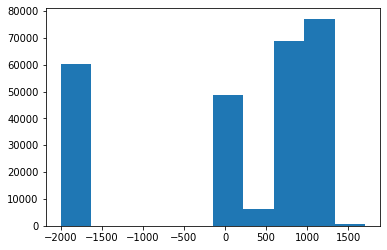

In [5]:
plt.hist(imgg.flatten())

(512, 512, 3)


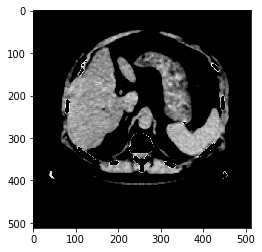

In [6]:
test = imgg.copy()
feature_array = np.empty((512,512,3))

for x in range(512):
    for y in range(512):
        feature_array[x][y] = (x, y, (imgg[x][y] - 1000) * 5 if 1000 < imgg[x][y] < 1100 else 0)
        
print(feature_array.shape)
plt.imshow(feature_array[:,:,2], cmap='gray')
# plt.plot(feature_array[:, 270, 2])
plt.show()

In [7]:
from sklearn.cluster import DBSCAN as Dbscan

db = Dbscan(eps = 15, min_samples=15)
predicted = db.fit_predict(feature_array.flatten().reshape(-1, 3)).reshape(512,512)

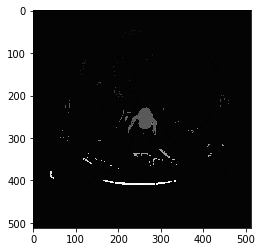

In [8]:
# fig = plt.figure(figsize=(20,20))
plt.imshow(predicted, cmap='gray')

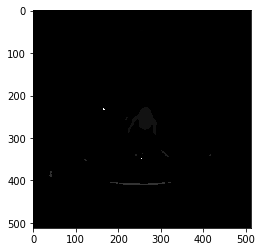

In [9]:
from cv2 import erode

img = predicted.astype('uint8')
kernel = np.ones((2,2),dtype=np.uint8) # this must be tuned 
img=erode(img,kernel)
img = cv2.medianBlur(img, 5)

plt.imshow(img, cmap='gray')

center 262 257

Perimeter: 295.90663504600525
Area: 1900.0
Diameter: 80


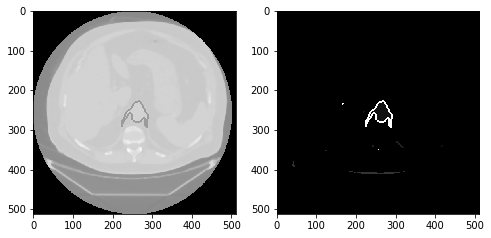

In [10]:
import math

img2 = img.copy()
contours,hierarchy = cv2.findContours(img,cv2.RETR_TREE,1)
cir = 0

for c in contours:
    
    perimeter = cv2.arcLength(c, True)
    area = cv2.contourArea(c)

    # GET center of contours
    M = cv2.moments(c)  
    
    try:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
    except ZeroDivisionError:
        cX = int(M["m10"])
        cY = int(M["m01"])
    
    if perimeter == 0 or (area > 2000 or area < 500) or (cX < 220 or cX > 320) or (cY < 250 or cY > 300):
        continue
        
    else:
        
        print('center', cX, cY)
        
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius)
        circularity = 4*math.pi*(area/(perimeter*perimeter))

        if 0.2 < circularity < 1.2:
            cir +=1
            cv2.drawContours(imgg, [c], -1, (255, 255, 0), 3)
            cv2.drawContours(img, [c], -1, (255, 255, 0), 3)

        # print("<> Total circles " +  str(cir) + "\n\n")
        print("\nPerimeter: " + str(perimeter))
        print("Area: " + str(area))
        print("Diameter: " + str(radius*2))

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()
ax[0].imshow(imgg, cmap='gray')
ax[1].imshow(img, cmap='gray')

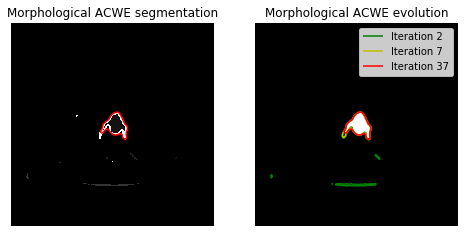

In [11]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Morphological ACWE
image = img_as_float(img)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 37, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 37")

ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)

plt.show()